<h1>Importation des librairies</h1>

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import time

<h1>Déclaration de différentes fonctions :</h1>
<h4>- Calcul de l'erreur quadratique</h4>
<h4>- Fonction d'activation Relu</h4>
<h4>- Fonction d'activation prelu pour éviter le <strong>dying relu problem</strong></h4>
<h4>- Fonction d'activation identité</h4>
<h4>- Fonction Xor</h4>

In [12]:
#fonction pour calculer l'erreur quadratique
def erreurQuadratique(yc,y, derive = False):
	if(derive):
		return sum(2*(yc - y))
	else:
		return sum((yc - y)**2)

#fonction d'activation relu
def relu(z, derive = False):
	if(derive):
		a = []
		for i in range(len(z)):
			tmp = 0
			if(z[i][0] > 0):
				tmp = 1
			a.append(tmp)
		return np.array(a).reshape((-1, 1))
	else:
		a = []
		for i in range(len(z)):
			a.append(max(0,z[i][0]))
		return np.array(a).reshape((-1, 1))

# fonction parameterized relu 
def prelu(z, alpha = 0.01, derive = False):
	if(derive):
		a = []
		for i in range(len(z)):
			tmp = alpha
			if(z[i][0] > 0):
				tmp = 1
			a.append(tmp)
		return np.array(a).reshape((-1, 1))
	else:
		a = []
		for i in range(len(z)):
			a.append(max(alpha * z[i][0], z[i][0]))
		return np.array(a).reshape((-1, 1))

#fonction d'activation identite
def identite(z, derive = False):
	if(derive):
		return np.ones(z.shape)
	else:
		return z

#fonction xor
xor = np.vectorize(lambda x1, x2: 1 if x1 * x2 >= 0 else -1)

<h1>Classe pour représenter une couche d'un réseau de neurones</h1>

In [14]:
class Layer:
	def __init__(self, sizeLayer, inputSize, activationfunction):
		self.w = np.random.randn(sizeLayer, inputSize)
		self.b = np.random.randn(sizeLayer, 1)
		self.f = activationfunction
	
	#effectue le calcul w(l) * a(l-1) + b(l) = z(l)
	#l représente le numéro de couche
	def calculZ(self, a):
		return self.w.dot(a) + self.b
	
	#activation de z
	def activeZ(self, z):
		return self.f(z)

<h1>Classe pour représenter un réseau de neurones</h1>

In [19]:
class NeuronalNetwork:
	# layers : un tableau -> nombre de neurones dans chaque couche
	# le nombre de valeurs en sortie est déterminé par le nombre de neurones de la dernière couche
	# inputSize : nombre de valeurs en entrée
	# functions : un vecteur -> ( fonctions d'activations des couches cachés,
	#							 fonction d'activation de la dernière couche,
	#							 fonction de calcul du coût )					   
	def __init__(self, layers, inputSize, functions):
		self.layers = []
		self.costFunction = functions[2]
		
		for i in range(len(layers)):
			j = inputSize
			k = layers[i]
			if(i != 0):
				j = layers[i-1]
			self.layers.append(Layer(k,j,functions[0]))
		self.layers[-1].f = functions[1]
	
	#effectue la propagation avant pour prédire ŷ
	def predict(self, x, stocker = False):
		#vérifie que x est sous le bon format, sinon, le convertit pour correspondre
		if(type(x) != np.ndarray):
			x = np.array(x)
		if(len(x.shape) == 1):
			x = x.reshape(-1,1)
		
		#propagation avant
		a = x
		stockZ = [0]
		stockA = [a]
		for layer in self.layers:
			z = layer.calculZ(a)
			a = layer.activeZ(z)
			stockZ.append(z)
			stockA.append(a)
		if(stocker):
			return a, stockZ, stockA
		else:
			return a
	
	#effectue la propagation avant sur un échantillon de valeurs
	def predictMatrice(self, X):
		Y = self.predict(X[0])
		for i in range(1,X.shape[0]):
			Y = np.concatenate((Y,self.predict(X[i])))
		return Y
	
	#effectue la rétropropagation
	def retropropagation(self, x, y, alpha):
		#calcul du ŷ obtenu par le réseau de neurones
		yc, z, a = self.predict(x,True)
		#Initialisation
		ga = self.costFunction(yc,y, True)
		#boucle
		for l in range(len(self.layers), 0, -1):
			gz = ga * self.layers[l-1].f(z[l], derive = True)
			self.layers[l-1].nablaB = gz
			self.layers[l-1].nablaW = gz.dot(a[l-1].T)
			ga = self.layers[l-1].w.T.dot(gz)
		
		#mise à jour des matrices de poids et de biais
		for l in range(len(self.layers)):
			self.layers[l].w = self.layers[l].w - alpha * self.layers[l].nablaW
			self.layers[l].b = self.layers[l].b - alpha * self.layers[l].nablaB
	
	#fonction d'entrainement, effectue la retropropagation plusieurs fois pour l'ensemble des données X
	def fit(self, x, y, alpha, epoch):
		eqmEpoch = []
		eqm = 0
		for i in range(epoch):
			#print(i + 1, "/", epoch)
			for j in range(x.shape[0]):
				self.retropropagation(x[j].reshape(-1,1),y[j],alpha)
			for j in range(x.shape[0]):
				eqm += self.costFunction(self.predict(x[j]),y[j])
			eqmEpoch.append(eqm / (x.shape[0] * (i + 1)))
		return eqmEpoch

<h1>Test de la propagation avant et arrière avec les valeurs calculés sur papier en classe
	pour vérifier que les calculs effectués par le réseau de neurones correspondent</h1>

In [16]:
def verification():
	#initialisation du réseau de neurones avec les données pris sur le dm
	ia = NeuronalNetwork([3,2,1],2,(relu, identite, erreurQuadratique))
	ia.layers[0].w = np.array([[0,-1],[2,-3],[1,-1]])
	ia.layers[1].w = np.array([[0,1,-1],[2,-2,1]])
	ia.layers[2].w = np.array([[2,-1]])
	ia.layers[0].b = np.array([0,1,-1]).reshape(-1,1)
	ia.layers[1].b = np.array([1,-2]).reshape(-1,1)
	ia.layers[2].b = np.array([0]).reshape(1,1)

	x = np.array([1,-2]).reshape(-1,1)
	y = np.array([1]).reshape(1,1)

	print("#######")
	print("resultats propagation avant :",ia.predict(x))
	print("#######\nresultats retropropagation : \nnabla_W :")
	ia.retropropagation(x,y,0.001)
	for layer in ia.layers:
		print(layer.nablaW)
		print("#######")
	print("nabla_B :")
	for layer in ia.layers:
		print(layer.nablaB)
		print("#######")
    
verification()

#######
resultats propagation avant : [[16]]
#######
resultats retropropagation : 
nabla_W :
[[   0.   -0.]
 [  60. -120.]
 [ -60.  120.]]
#######
[[120. 540. 120.]
 [ -0.  -0.  -0.]]
#######
[[240.   0.]]
#######
nabla_B :
[[  0.]
 [ 60.]
 [-60.]]
#######
[[60.]
 [-0.]]
#######
[[30.]]
#######


<h1>Exemple d'application du réseau de neurones sur une fonction affine</h1>

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


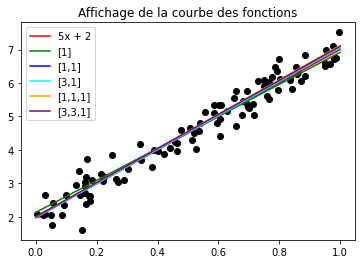

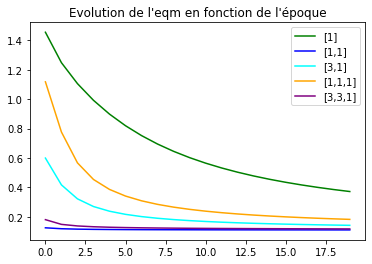

In [17]:
def regression_lineaire(x, x2, y):
	#test équivalent à la régression linéaire
	
	ia = NeuronalNetwork([1], 1, (None,identite,erreurQuadratique))
	eqm = ia.fit(x, y, 0.01, 20)
	yc = ia.predictMatrice(x2)
	
	plt.plot(x2,yc, color = "green", label = "[1]")
	#plt.show()
	return eqm

def affine_avec_couches_cachees(x, x2, y, couches, colorp, labelp):
	#contient cette fois-ci des couches cachées données en paramètres
	ia = NeuronalNetwork(couches, 1, (identite,identite,erreurQuadratique))
	eqm = ia.fit(x, y, 0.01, 20)
	
	yc = ia.predictMatrice(x2)
	
	plt.plot(x2,yc, color = colorp, label = labelp)
	#plt.show()
	return eqm

def test_affine():
	#génération d'un echantillon de 100 valeurs x aléatoires
	#et un echantillon de valeurs x2 pour afficher la droite à prédire avec pyplot
	echantillon = 100
	x = (np.random.rand(echantillon,1)).reshape(-1,1)
	x2 = np.linspace(0, 1, echantillon).reshape(-1,1)
	y = x * 5 + 2 + 0.4 * np.random.randn(echantillon, 1)
	y2 = x2 * 5 + 2
	plt.scatter(x,y, color = "black")
	plt.plot(x2,y2, color = "red", label = "5x + 2")

	#test d'entrainements
	#affichage des courbes représentant la fonction approximée par le réseau de neurones
	eqm1 = regression_lineaire(x,x2,y)
	eqm2 = affine_avec_couches_cachees(x,x2,y, [1,1], "blue", "[1,1]")
	eqm3 = affine_avec_couches_cachees(x,x2,y, [3,1], "cyan", "[3,1]")
	eqm4 = affine_avec_couches_cachees(x,x2,y, [1,1,1], "orange", "[1,1,1]")
	eqm5 = affine_avec_couches_cachees(x,x2,y, [3,3,1], "purple", "[3,3,1]")
	plt.title("Affichage de la courbe des fonctions")
	plt.legend()
	plt.show()
	
	#affichage de l'évolution de l'erreur quadratique de chaque réseau de neurones
	plt.plot(list(range(20)),eqm1, color = "green", label = "[1]")
	plt.plot(list(range(20)),eqm2, color = "blue", label = "[1,1]")
	plt.plot(list(range(20)),eqm3, color = "cyan", label = "[3,1]")
	plt.plot(list(range(20)),eqm4, color = "orange", label = "[1,1,1]")
	plt.plot(list(range(20)),eqm5, color = "purple", label = "[3,3,1]")
	plt.legend()
	plt.title("Evolution de l'eqm en fonction de l'époque")
	plt.show()
    
test_affine()

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


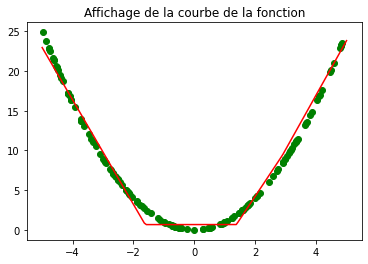

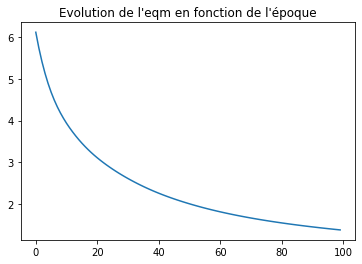

In [18]:
def polynomialTest():
	#test sur fonction polynomial avec une couche cachée de 3 neurones
	echantillon = 150
	x = (np.random.rand(echantillon,1) - 0.5) * 10
	x.reshape(-1,1)
	x2 = np.linspace(-5, 5, echantillon).reshape(-1,1)
	y = x**2
	
	ia = NeuronalNetwork([3,1], 1, (prelu,identite,erreurQuadratique))
	eqm = ia.fit(x, y, 0.001, 100)
	yc = ia.predictMatrice(x2)
	
	plt.scatter(x,y, color = "green")
	plt.plot(x2,yc, color = "red")
	plt.title("Affichage de la courbe de la fonction")
	plt.show()
	
	plt.plot(list(range(100)), eqm)
	plt.title("Evolution de l'eqm en fonction de l'époque")
	plt.show()
    
polynomialTest()

Taux d'erreur : 1.1033 %


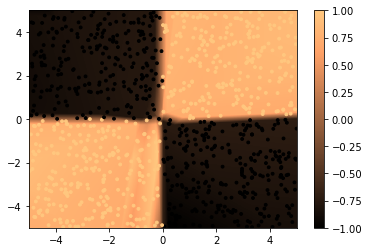

In [24]:
#effectue la prédiction de valeurs sur les valeurs d'entrée x1 et x2 générés par plt.meshgrid
def calc(ia,x1,x2):
	yc = ia.predict([x1,x2])
	return yc

calc = np.vectorize(calc)

#calcule et affiche le taux d'erreur pour l'approximation de la fonction xor
def tauxErreurXor(yc,ya):
	yc = yc.reshape(1,-1)
	ya = ya.reshape(1,-1)
	cptErreur = 0
	for i in range(yc.shape[1]):
		tmp = 0
		if(yc[0][i] < 0):
			tmp = -1
		else:
			tmp = 1
		if(tmp != ya[0][i]):
			cptErreur += 1
	print("Taux d'erreur :", cptErreur * 100 / yc.shape[1], "%")

def xorTest():
	#test sur fonction Xor avec 3 couches cachées de 6 neurones
	echantillon = 1000
	x = (np.random.rand(echantillon,2) - 0.5) * 10
	x.reshape(-1,1)
	
	ia = NeuronalNetwork([6,6,6,1], 2, (prelu,identite,erreurQuadratique))
	y = xor(x[:,0], x[:,1])
	
	eqm = ia.fit(x, y, 0.001, 100)

	xtest = np.linspace(-5,5,echantillon)
	X1,X2 = np.meshgrid(xtest , xtest)
	yc = calc(ia,X1,X2)
	ya = xor(X1,X2)
	tauxErreurXor(yc,ya)

	plt.pcolormesh(X1,X2,yc, cmap = "copper", shading = 'auto')
	plt.scatter(x[:,0],x[:,1], c = y, cmap = "copper", s = 8)
	plt.colorbar()
	plt.show()

xorTest()